1 and 2 parameter bifurcation diagrams for vdp-thal

# Imports

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
import response as rp

import vdp_thal

import importlib
import lib

from lib.util import (get_phase, freq_est,follow_phase_diffs,follow_phase_diffs_del,
                        follow_phase_diffs_u,follow_phase_diffs_u_del,
get_smallest_eps,get_largest_eps, get_es_min, get_es_max)

from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined, 
                            draw_quick_plot_f, add_diagram_1d_del_scatter)

import lib.rhs

importlib.reload(sys.modules['lib.util'])
importlib.reload(sys.modules['lib.rhs'])
from lib.util import (get_phase, freq_est)
#from lib.rhs import (_redu)
from lib.rhs import _redu_c2, _full, _full_mono_rhs

_redu = _redu_c2

from importlib import reload
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import os
from matplotlib.patches import Circle

from scipy.optimize import root,bisect
from copy import deepcopy

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

# Dicts

In [2]:
kw_sim = {'rtol':1e-7,'atol':1e-7,'method':'LSODA'}

In [3]:
pd_thal = {'gL':0.05,'gna':3,'gk':5,
           'gt':5,'eL':-70,'ena':50,
           'ek':-90,'et':0,'esyn':-100,
           'c':1,'alpha':3,'beta':2,
           'sigmat':0.8,'vt':-20,'del':0,
           'ib':8.2,'om':1,'om_fix':1}

pd_vdp = {'mu':.04,'sigmat':0.1,'vt':1,
          'alpha':3,'beta':2,'esyn':-2,
          'del':0,'om':1,'om_fix':1}

In [4]:
# default period must be 2*np.pi
kws_thal = {'var_names':['v','h','r','w'],
            'pardict':pd_thal,
            'rhs':vdp_thal.rhs_thal,
            'coupling':vdp_thal.coupling_thal,
            'init':np.array([-.64,0.71,0.25,0,6]),
            'TN':10000,
            'trunc_order':1,
            'z_forward':False,
            'i_forward':False,
            'i_bad_dx':[False,True,False,False,False,False],
            'max_iter':20,
            'rtol':1e-12,
            'atol':1e-12,
            'rel_tol':1e-9,
            'save_fig':True,
            'lc_prominence':.05}

kws_vdp = {'var_names':['v','h','w'],
               'pardict':pd_vdp,
               'rhs':vdp_thal.rhs_vdp,
               'coupling':vdp_thal.coupling_vdp,
               'init':np.array([.32,0.128,0.54,20]),
               'TN':10000,
               'trunc_order':1,
               'z_forward':False,
               'i_forward':False,
               'i_bad_dx':[False,True,False,False,False,False],
               'max_iter':20,
               'rtol':1e-10,
               'atol':1e-10,
               'rel_tol':1e-8,
               'save_fig':True,
               'lc_prominence':.05}

In [5]:
het_coeffs = [1,20]

# Defs

In [6]:
mname1 = 'vdp_thal11_b={}'
mname2 = 'vdp_thal11_b2={}'
mname3 = 'vdp_thal11_b3={}'

mname_list = ['vdp_thal11_b'+str(i)+'={}' for i in range(5)]

In [7]:
#### es_min,phi0 = get_es_min(data_bs_list,data_bu_list)
def get_monodromy_full(es_min,phi0,a,b,mname='',tol=1e-6,recompute=False):
    """
    es_min: minimum epsilon to use
    a: nmCoupling object
    b: het. parameter.
    mnamei are the model names to save the monodromy matrix and related calculations
    """    

    kw_b = {'a':a,'b':b,'recompute':recompute,'bifdir':'bif1d_vdp_thal/','_full_rhs':_full}
    print('es_min,phi0',es_min,phi0)
    # the _u function has the ability to save and load Y values
    _,Y = follow_phase_diffs(**dict(phi0=phi0,eps_init=es_min,eps_final=es_min-.01,deps=-1),max_time=10000,tol=tol,return_point=True,**kw_b)

    print('Y',Y)
    # define parameters for finding monodromy of full system
    pd_vdp_thal = {**a.system1.pardict,**a.system2.pardict}
    pd_vdp_thal['b']=b
    pd_vdp_thal['a']=a
    
    pd_vdp_thal['eps']=es_min
    # print(pd1['del0'])
    
    # default period must be 2*np.pi
    kws_vdp_thal = {'var_names':['v0','h0','r0','w0','v1','h1','w1'],
                    'pardict':pd_vdp_thal,
                    'rhs':_full_mono_rhs,
                    'coupling':lambda x: 0*x,
                    'init':Y, # from above
                    'use_init':True, # use init for direct LC calculation
                    'TN':50000,
                    'mode':'none', # forces not normalizing period.
                    'rtol_lc':1e-10,
                    'atol_lc':1e-10,
                    'trunc_order':0,
                    'z_forward':False,
                    'i_forward':False,
                    'i_bad_dx':[False,True,False,False,False,False],
                    'save_fig':False,
                    'max_iter':50,
                    'max_time_lc':5000,
                    'tol_root_lc':1e-8,
                    'halt_after_mono':True}

    m1 = rsp(idx='',model_name=mname,**kws_vdp_thal)

    return m1

In [8]:
def compute_sol_all(a,eps,phi0,b,T=2000,dt=.01):
    """
    only for use in jupyter
    """
    t = np.arange(0,T,dt)
    args = {'args':(a,eps,b), 't_eval':t,**kw_sim}

    y0a = a.system1.lc['dat'][int((phi0/(2*np.pi)) * a.system1.TN),:]
    y0b = a.system2.lc['dat'][int((0/(2*np.pi)) * a.system2.TN),:]
    y0 = np.concatenate([y0a,y0b]).flatten()
    #a.system1.pardict['del0'] = b

    # tot = 0
    # for i in range(len(a.het_coeffs)):
    #     tot += eps**i*b**(i+1)*a.het_coeffs[i]
    # a.system1.pardict['del0'] = tot
    # print(a.system1.pardict['del0'])
    # print(pd1['del0'])
    
    
    solf = solve_ivp(_full,[0,t[-1]], y0, **args)

    args['args'] = (a,eps,b,1)
    solr_o1 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    args['args'] = (a,eps,b,2)
    solr_o2 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,3)
    #solr_o3 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,4)
    #solr_o4 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)

    return solf, solr_o1, solr_o2#, solr_o3, solr_o4


def load_sol_all(a,eps,phi0,b,T,dt=.01,path_loc='sols_temp/',recompute=False,
                 return_full=False,**kwargs):
    if (not os.path.exists(path_loc)):
        os.makedirs(path_loc)
    
    fname_f = path_loc+'sol_f_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)
    fname_r = path_loc+'sol_r_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)
    file_dne = not(os.path.isfile(fname_f))
    file_dne += not(os.path.isfile(fname_r))

    if file_dne or recompute:
        solf, solr_o1, solr_o2 = compute_sol_all(a,eps,phi0,b,T=T,dt=dt)

        # phase of full model
        ta, pha = get_phase(solf.t,solf.y.T[:,:4], skipn=200,system1=a.system1)
        tb, phb = get_phase(solf.t,solf.y.T[:,4:], skipn=200,system1=a.system2)

        dat1 = np.zeros([len(ta),2])
        dat1[:,0] = ta
        dat1[:,1] = np.mod(pha - a.om*phb,2*np.pi)

        dat2 = np.zeros([len(solr_o1.t),5])
        dat2[:,0] = solr_o1.t
        dat2[:,1] = solr_o1.y[0]
        dat2[:,2] = solr_o2.y[0]
        #dat2[:,3] = solr_o3.y[0]
        #dat2[:,4] = solr_o4.y[0]

        np.savetxt(fname_f,dat1)
        np.savetxt(fname_r,dat2)

    else:
        dat1 = np.loadtxt(fname_f)
        dat2 = np.loadtxt(fname_r)
    return dat1, dat2

# Initialize Response

In [9]:
system1 = rsp(idx=0,model_name='vdp_thal0',**kws_thal)
system2 = rsp(idx=1,model_name='vdp_thal1',**kws_vdp)

mkdir ./data/vdp_thal0/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0084015231173136
self.T 6.283185307179586
LC0 ini[-0.10425117  0.22993228  0.09898925  0.40570217]
LC0 fin[-0.10425117  0.22993228  0.09898925  0.40570217]
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.024653498269982924
* Loading g symbolic...
* Computing g...
g0 ini[0. 0. 0. 0.]
g0 fin[0. 0. 0. 0.]
g1 ini[ 0.00253413 -0.64088722 -0.22868543  0.73277563]
g1 fin[ 0.00253409 -0.64088719 -0.22868543  0.73277558]
* Loading heterogeneous terms...
* Computing z...
z0 ini[-0.87597607 -1.17574397  3.28529655 -0.        ]
z0 fin[-0.87597607 -1.17574397  3.28529652 -0.        ]
z1 ini[-1.70646067 -0.61636896  0.14424813  0.        ]
z1 fin[-1.70646067 -0.61636896  0.14424813  0.        ]
* Computing i...
i0 ini[-0.23544813  0.01818327 -4.42638639  0.        ]
i0 fin[-0.23544811  0.01818329 -4.4263864   0.        ]
i1 ini[-9.66309554e-02  7.45216330e-01 -6.49855309e-02  8.64027668e-21]

# Initialize Coupling 1:1

In [10]:
# parameters to be fixed for 1 par diagrams
nm_tup = (1,1)

In [11]:
a11 = nm.nmCoupling(system1,system2,
                    #recompute_list=['k_gwt1','p_gwt1'],
                    #recompute_list=['p_data_gwt0','p_data_gwt1','h_data_gwt0','h_data_gwt1'],
                    #recompute_list=recompute_list,
                    _n=('om0',nm_tup[0]),_m=('om1',nm_tup[1]),
                    het_coeffs=het_coeffs,
                    NH=1024)

Initializing 11 Coupling...
pfactor 29
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H vdp_thal0, order=0...
* Loading H vdp_thal1, order=0...
* Loading H vdp_thal0, order=1...
* Loading H vdp_thal1, order=1...


In [12]:
a11.system2.rhs(0,[1,0,0],a11.system2.pardict,'val',1)

array([0.02666933, 1.0001    , 1.50014999])

## Phase line

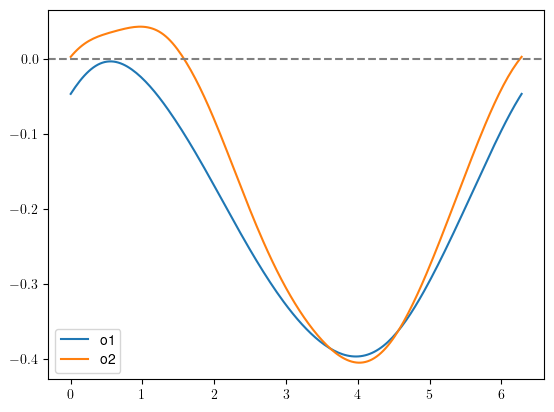

In [13]:
a = a11
e = .3
b = .007
x_temp2 = np.linspace(0,2*np.pi,200)

rhs1 = _redu(0,x_temp2,a,e,b,miter=1)
rhs2 = _redu(0,x_temp2,a,e,b)

fig,axs = plt.subplots()
axs.plot(x_temp2,rhs1,label='o1')
axs.plot(x_temp2,rhs2,label='o2')
axs.axhline(0,0,2*np.pi,ls='--',color='gray')
axs.legend()

In [14]:
# define aliases as a template
a = a11

nm_val = str(nm_tup[0])+str(nm_tup[1])

In [15]:
etup = (.005,.1,100)
dtup = (-.4,.2)

## Plot 1par eps

In [16]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=0.007,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [17]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=0.0065,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [18]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=0.006,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [19]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=0.0055,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [20]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=0.005,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [21]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=0,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [22]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=-.01,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [23]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=-.1,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [24]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=-.2,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [25]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=-.21,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [26]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=-.215,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [27]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=-.22,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [28]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=-.3,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [29]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=-.4,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [30]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=-.5,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

## Plot 1par del

In [31]:
# fig,axs = plt.subplots(1,2,figsize=(6,2))
# kw_diagram = dict(a=a,eps=e1,del_tup=dtup,rhs=_redu_c2)
# add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)
# axs[0].set_xlabel('del'); axs[1].set_xlabel('del')

In [32]:
# fig,axs = plt.subplots(1,2,figsize=(6,2))
# kw_diagram = dict(a=a,eps=e2,del_tup=dtup,rhs=_redu_c2)
# add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

## EPS VARY

In [33]:
kw_b = {'a':a,'b':0,'recompute':False,'bifdir':'bif1d_vdp_thal/','_full_rhs':_full}
fname_bs = kw_b['bifdir']+'hyper_gwt_'+nm_val+'_b={}_s.txt'
fname_bu = kw_b['bifdir']+'hyper_gwt_'+nm_val+'_b={}_u.txt'

In [34]:
b_vals_full = []
e_vals_full = [] # save min eps values for all diagrams
e_hi_full = [] # save max eps values for all diagrams

## monodromy calculations
e_vals_mono_min = [] # save eps values at min monodromy
eigenvalues_min_all = []
b_min_all = []

e_vals_mono_max = [] # save eps values at max monodromy
eigenvalues_max_all = []
b_max_all = []

### b=0.007

#### Sim

In [35]:
# a=a11;T=5000;b=0.007;e=.038;phi0 = 4
# dat1,dat2=load_sol_all(a=a,eps=e,phi0=phi0,b=b,T=T,recompute=False)
# t1=dat1[:,0];y=dat1[:,1]
# t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]

# fig,axs = plt.subplots(figsize=(4,2))

# axs.scatter(t1,y,s=1,alpha=.5,color='black')

# axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
# axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

# axs.set_ylim(-.5,2*np.pi+.5)
# axs.legend()

##### Original

In [36]:
# # show original system
# a=a11;T=1000;b=0.007;e=.02;phi0 = 4
# solf, solr_o1, solr_o2 = compute_sol_all(a,e,phi0,b,T=T,dt=.01)

In [37]:
# fig,axs = plt.subplots(figsize=(4,2))
# axs.plot(solf.t,solf.y[0])
# # axs.plot(solf.t,solf.y[3])
# axs.plot(solf.t,solf.y[4])
# axs.set_xlim(800,1000)

#### Branches eps stable

In [38]:
b=0.007
kw_b['recompute'] = False
kw_b['b'] = b

In [39]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=.65,eps_init=0.05,eps_final=0,deps=-.001),
            dict(phi0=.7,eps_init=0.049,eps_final=0.1,deps=.002)]

In [40]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0.65
phi init 0.7


In [41]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [42]:
kw_b['recompute'] = False
kw_b['b'] = b

In [43]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [44]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=0.39,eps_init=0.045,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 0.39
phase_diffs_u_init=0.39_nm=11_b=0.007_ei=0.045_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.39_nm=11_b=0.007_ei=0.045_ef=0_de=-2.txt


In [45]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=0.0,eps_init=0.045,eps_final=0,deps=-.001),
            dict(phi0=0.1,eps_init=0.044,eps_final=0.1,deps=.002),
           ]

In [46]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 0.0
phase_diffs_u_init=0.0_nm=11_b=0.007_ei=0.045_ef=0_de=-0.001.txt
phase_diffs_u_pt_init=0.0_nm=11_b=0.007_ei=0.045_ef=0_de=-0.001.txt
phi init 0.1
phase_diffs_u_init=0.1_nm=11_b=0.007_ei=0.044_ef=0.1_de=0.002.txt
phase_diffs_u_pt_init=0.1_nm=11_b=0.007_ei=0.044_ef=0.1_de=0.002.txt


In [47]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

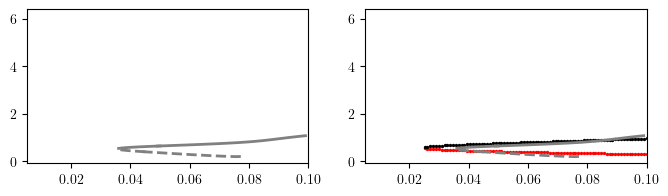

In [48]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [49]:
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)
print(es_min,phi0)

0.03599999999999999 [0.036      6.28686535 0.53409274]


In [50]:
# kw_b = {'a':a,'b':b,'recompute':True,'bifdir':'bif1d_vdp_thal/','_full_rhs':_full}

In [51]:
# #0.03949999999999999 0.5339927959575679
# dat = follow_phase_diffs(**dict(phi0=0.533992,eps_init=0.03949999999999999,eps_final=0,deps=-1,max_iter=50),**kw_b)

In [52]:
# get_init_phase_diff_c 0.5339927959575679 <nmCoupling.nmCoupling object at 0x0000016F8B462E90> 0.03949999999999999 0.007 1000 <function _full at 0x0000016F8B4353F0> 0.05 {}
# period_est 6.2900629006290085 time_est 992.569925699257
# plfull phi0 0.5339927959575679 init [-0.10536068  0.2384832   0.1074169   0.39884578  1.50497941 -0.85490702  0.52270477  6.2900629 ]
# eps 0.03949999999999999 coutner 0 b 0.007 dy [-0.0018309   0.09369536 -0.00124644 -0.1070631   0.04751769  0.09679378  0.02038869 -0.00928584] Y [-0.10536068  0.2384832   0.1074169   0.39884578  1.50497941 -0.85490702  0.52270477  6.2900629 ]

#### Monodromys min

In [53]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.03609999999999999 0.534092738461025
phi init 0.534092738461025
Y [-0.10481326  0.23732506  0.10733001  0.40021902  1.49155302 -0.93698999  0.51029153  6.28692291]
mkdir ./data/vdp_thal11_b0=0.007/
* Loading LC data...
self.T 6.286922496465298
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0006947596601976588
es_min,phi0 0.036599999999999994 0.534092738461025
phi init 0.534092738461025
Y [-0.10472188  0.23787312  0.10755506  0.39969338  1.47985451 -0.94875375  0.50550214  6.28721926]
mkdir ./data/vdp_thal11_b1=0.007/
* Loading LC data...
self.T 6.2872189953894075
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0009796859100894104
es_min,phi0 0.037099999999999994 0.534092738461025
phi init 0.534092738461025
Y [-0.10463219  0.23736005  0.1077533   0.40035988  1.47096808 -0.95567795  0.50195584  6.28746707]
mkdir ./data/vdp_thal11_b2=0.007/
* Loading LC data...
self.T 6.287466784270348
loaded coupling expansions

In [54]:
m1.eigenvalues

array([7.30605935e-02+0.j      , 9.99999997e-01+0.j      , 9.90020875e-01+0.j      , 8.48012787e-01+0.003735j, 8.48012787e-01-0.003735j, 6.94625308e-07+0.j      , 1.15376173e-08+0.j      ])

In [55]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=0.0065

#### Branches eps stable

In [56]:
b=0.0065
kw_b['recompute'] = False
kw_b['b'] = b

In [57]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=.65,eps_init=0.05,eps_final=0,deps=-.002),
            dict(phi0=.7,eps_init=0.049,eps_final=0.1,deps=.002)]

In [58]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0.65
phi init 0.7


In [59]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [60]:
kw_b['recompute'] = False
kw_b['b'] = b

In [61]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=.2,eps_init=0.04,eps_final=0.025,deps=-1),return_point=True,**kw_b)

phi init 0.2
phase_diffs_u_init=0.2_nm=11_b=0.0065_ei=0.04_ef=0.025_de=-1.txt
phase_diffs_u_pt_init=0.2_nm=11_b=0.0065_ei=0.04_ef=0.025_de=-1.txt


In [62]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=0.3,eps_init=0.04,eps_final=0,deps=-.002),
            dict(phi0=0.301,eps_init=0.039,eps_final=0.1,deps=.002),
           ]

In [63]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 0.3
phase_diffs_u_init=0.3_nm=11_b=0.0065_ei=0.04_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=0.3_nm=11_b=0.0065_ei=0.04_ef=0_de=-0.002.txt
phi init 0.301
phase_diffs_u_init=0.301_nm=11_b=0.0065_ei=0.039_ef=0.1_de=0.002.txt
phase_diffs_u_pt_init=0.301_nm=11_b=0.0065_ei=0.039_ef=0.1_de=0.002.txt


In [64]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

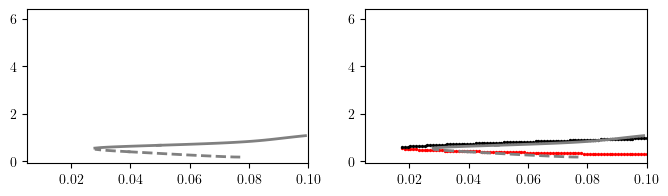

In [65]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [66]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.028099999999999983 0.5465377693941962
phi init 0.5465377693941962
Y [-0.10475486  0.23860698  0.10559738  0.39814428  1.53289278 -0.98847512  0.51604035  6.28623776]
mkdir ./data/vdp_thal11_b0=0.0065/
* Loading LC data...
self.T 6.28623737517936
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0005970293915519108
es_min,phi0 0.028599999999999983 0.5465377693941962
phi init 0.5465377693941962
Y [-0.1046389   0.23533079  0.10576628  0.40194888  1.52678016 -0.9914743   0.51418533  6.28644165]
mkdir ./data/vdp_thal11_b1=0.0065/
* Loading LC data...
self.T 6.2864412826987826
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0007848632246034769
es_min,phi0 0.029099999999999984 0.5465377693941962
phi init 0.5465377693941962
Y [-0.10458334  0.23179277  0.10592323  0.40602138  1.52227218 -0.99185756  0.51299596  6.28662235]
mkdir ./data/vdp_thal11_b2=0.0065/
* Loading LC data...
self.T 6.286622143639368
loaded coupling e

(0.9, 1.1)

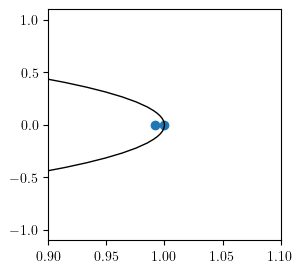

In [67]:
fig,axs = plt.subplots(figsize=(3,3))
axs.scatter(m1.eigenvalues.real,m1.eigenvalues.imag)

circ = Circle((0, 0), radius=1, edgecolor='k', facecolor='None'); axs.add_patch(circ)
axs.set_xlim(.9,1.1)

In [68]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=0.006

#### Sim

In [69]:
# a=a11;T=5000;b=0.006;e=.1;phi0 = 4
# dat1,dat2=load_sol_all(a=a,eps=e,phi0=phi0,b=b,T=T,recompute=False)
# t1=dat1[:,0];y=dat1[:,1]
# t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]

# fig,axs = plt.subplots(figsize=(4,2))

# axs.scatter(t1,y,s=1,alpha=.5,color='black')

# axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
# axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

# axs.set_ylim(-.5,2*np.pi+.5)
# axs.legend()

#### Branches eps stable

In [70]:
b=0.006
kw_b['recompute'] = False
kw_b['b'] = b

In [71]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=.65,eps_init=0.05,eps_final=0,deps=-.002),
            dict(phi0=.7,eps_init=0.049,eps_final=0.1,deps=.002)]

In [72]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0.65
phi init 0.7


In [73]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [74]:
kw_b['recompute'] = False
kw_b['b'] = b

In [75]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=.0,eps_init=0.04,eps_final=0.025,deps=-1),return_point=True,**kw_b)

phi init 0.0
phase_diffs_u_init=0.0_nm=11_b=0.006_ei=0.04_ef=0.025_de=-1.txt
phase_diffs_u_pt_init=0.0_nm=11_b=0.006_ei=0.04_ef=0.025_de=-1.txt


In [76]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=0.11,eps_init=0.04,eps_final=0,deps=-.002),
            dict(phi0=0.1,eps_init=0.039,eps_final=0.1,deps=.002),
           ]

In [77]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 0.11
phase_diffs_u_init=0.11_nm=11_b=0.006_ei=0.04_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=0.11_nm=11_b=0.006_ei=0.04_ef=0_de=-0.002.txt
phi init 0.1
phase_diffs_u_init=0.1_nm=11_b=0.006_ei=0.039_ef=0.1_de=0.002.txt
phase_diffs_u_pt_init=0.1_nm=11_b=0.006_ei=0.039_ef=0.1_de=0.002.txt


In [78]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

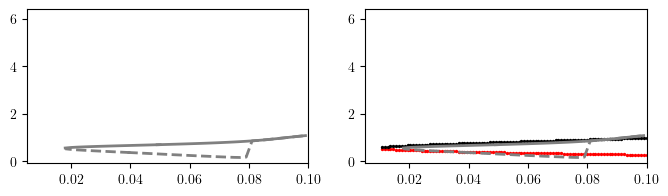

In [79]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [80]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.018099999999999974 0.5510408498516144
phi init 0.5510408498516144
Y [-0.1046083   0.22869295  0.10322922  0.40857295  1.5999396  -1.01469228  0.52889182  6.28514415]
mkdir ./data/vdp_thal11_b0=0.006/
* Loading LC data...
self.T 6.285143737606674
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0002891093378143244
es_min,phi0 0.018599999999999974 0.5510408498516144
phi init 0.5510408498516144
Y [-0.10454977  0.23281565  0.10340759  0.40397162  1.58512807 -1.03195383  0.52416568  6.28529644]
mkdir ./data/vdp_thal11_b1=0.006/
* Loading LC data...
self.T 6.285296104413011
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00041986273992872383
es_min,phi0 0.019099999999999975 0.5510408498516144
phi init 0.5510408498516144
Y [-0.10453986  0.22932153  0.10354524  0.40798633  1.58090779 -1.03238448  0.52322339  6.28543051]
mkdir ./data/vdp_thal11_b2=0.006/
* Loading LC data...
self.T 6.285430248030678
loaded coupling exp

In [81]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=0.003

#### Sim

In [82]:
# a=a11;T=5000;b=0.0035;e=.05;phi0 = 4
# dat1,dat2=load_sol_all(a=a,eps=e,phi0=phi0,b=b,T=T,recompute=False)
# t1=dat1[:,0];y=dat1[:,1]
# t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]

# fig,axs = plt.subplots(figsize=(4,2))

# axs.scatter(t1,y,s=1,alpha=.5,color='black')

# axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
# axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

# axs.set_ylim(-.5,2*np.pi+.5)
# axs.legend()

#### Branches eps stable

In [83]:
b=0.003
kw_b['recompute'] = False
kw_b['b'] = b

In [84]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=1,eps_init=0.05,eps_final=0,deps=-.002),
            dict(phi0=1,eps_init=0.049,eps_final=0.1,deps=.002)]

In [85]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [86]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [87]:
kw_b['recompute'] = False
kw_b['b'] = b

In [88]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=.05,eps_init=0.05,eps_final=0.045,deps=-.01),return_point=True,**kw_b)

phi init 0.05
phase_diffs_u_init=0.05_nm=11_b=0.003_ei=0.05_ef=0.045_de=-0.01.txt
phase_diffs_u_pt_init=0.05_nm=11_b=0.003_ei=0.05_ef=0.045_de=-0.01.txt


In [89]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=0.05,eps_init=0.05,eps_final=0,deps=-.002),
            dict(phi0=0.05,eps_init=0.049,eps_final=0.1,deps=.002)
           ]

In [90]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 0.05
phase_diffs_u_init=0.05_nm=11_b=0.003_ei=0.05_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=0.05_nm=11_b=0.003_ei=0.05_ef=0_de=-0.002.txt
phi init 0.05
phase_diffs_u_init=0.05_nm=11_b=0.003_ei=0.049_ef=0.1_de=0.002.txt
phase_diffs_u_pt_init=0.05_nm=11_b=0.003_ei=0.049_ef=0.1_de=0.002.txt


In [91]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

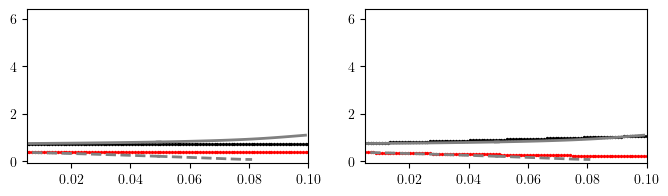

In [92]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [93]:
b_vals_full.append(b)

es = 0
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=0

#### Sim

In [94]:
# a=a11;T=5000;b=0.0;e=.05;phi0 = 4
# dat1,dat2=load_sol_all(a=a,eps=e,phi0=phi0,b=b,T=T,recompute=False)
# t1=dat1[:,0];y=dat1[:,1]
# t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]

# fig,axs = plt.subplots(figsize=(4,2))

# axs.scatter(t1,y,s=1,alpha=.5,color='black')

# axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
# axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

# axs.set_ylim(-.5,2*np.pi+.5)
# axs.legend()

#### Branches eps stable

In [95]:
b=0
kw_b['recompute'] = False
kw_b['b'] = b

In [96]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=1,eps_init=0.05,eps_final=0,deps=-.002),
            dict(phi0=1,eps_init=0.049,eps_final=0.1,deps=.002)]

In [97]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [98]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [99]:
kw_b['recompute'] = False
kw_b['b'] = b

In [100]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=.05,eps_init=0.05,eps_final=0.045,deps=-.01),return_point=True,**kw_b)

phi init 0.05
phase_diffs_u_init=0.05_nm=11_b=0_ei=0.05_ef=0.045_de=-0.01.txt
phase_diffs_u_pt_init=0.05_nm=11_b=0_ei=0.05_ef=0.045_de=-0.01.txt


In [101]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=0.05,eps_init=0.05,eps_final=0,deps=-.002),
            dict(phi0=0.05,eps_init=0.049,eps_final=0.1,deps=.002)
           ]

In [102]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 0.05
phase_diffs_u_init=0.05_nm=11_b=0_ei=0.05_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=0.05_nm=11_b=0_ei=0.05_ef=0_de=-0.002.txt
phi init 0.05
phase_diffs_u_init=0.05_nm=11_b=0_ei=0.049_ef=0.1_de=0.002.txt
phase_diffs_u_pt_init=0.05_nm=11_b=0_ei=0.049_ef=0.1_de=0.002.txt


In [103]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

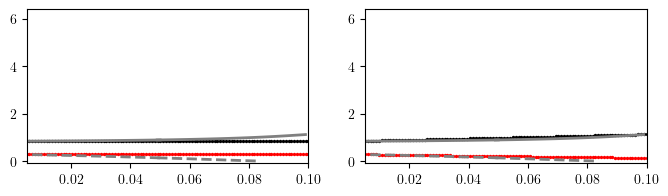

In [104]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [105]:
# b_vals_full.append(b)

# es = 0
# eu = get_smallest_eps(data_bu_list)

# e_vals_full.append(np.min([es,eu]))

# es = get_largest_eps(data_bs_list)
# eu = get_largest_eps(data_bu_list)

# e_hi_full.append(np.max([es,eu]))

### b=-.1

#### Branches eps stable

In [106]:
b=-.1
kw_b['recompute'] = False
kw_b['b'] = b

In [107]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=2,eps_init=0.11,eps_final=0,deps=-.002)]

In [108]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2


In [109]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [110]:
kw_b['recompute'] = False
kw_b['b'] = b

In [111]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5.5,eps_init=0.03,eps_final=0.01,deps=-1),return_point=True,**kw_b)

phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.1_ei=0.03_ef=0.01_de=-1.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.1_ei=0.03_ef=0.01_de=-1.txt


In [112]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=5.5,eps_init=0.03,eps_final=0,deps=-.002),
            dict(phi0=5.5,eps_init=0.029,eps_final=0.1,deps=.002)]

In [113]:
data_bu_list = []
Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.1_ei=0.03_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.1_ei=0.03_ef=0_de=-0.002.txt
phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.1_ei=0.029_ef=0.1_de=0.002.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.1_ei=0.029_ef=0.1_de=0.002.txt


In [114]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

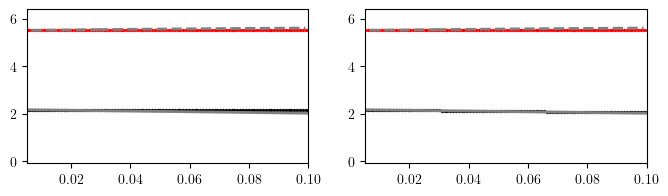

In [115]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [116]:
b_vals_full.append(b)

es = 0
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.2

#### Branches eps stable

In [117]:
b=-.2
kw_b['recompute'] = False
kw_b['b'] = b

In [118]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=2,eps_init=0.11,eps_final=0,deps=-.002)]

In [119]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2


In [120]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [121]:
kw_b['recompute'] = False
kw_b['b'] = b

In [122]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5.5,eps_init=0.05,eps_final=0.0,deps=-1),return_point=True,**kw_b)

phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.2_ei=0.05_ef=0.0_de=-1.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.2_ei=0.05_ef=0.0_de=-1.txt


In [123]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=5.5,eps_init=0.05,eps_final=0,deps=-.002),
            dict(phi0=5.5,eps_init=0.049,eps_final=0.1,deps=.002)] 

In [124]:
data_bu_list = []
Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.2_ei=0.05_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.2_ei=0.05_ef=0_de=-0.002.txt
phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.2_ei=0.049_ef=0.1_de=0.002.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.2_ei=0.049_ef=0.1_de=0.002.txt


In [125]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

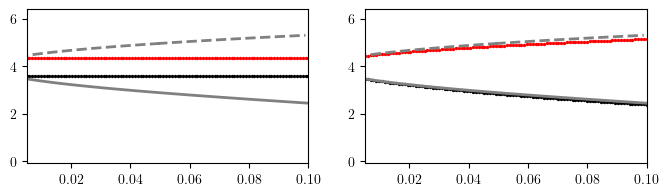

In [126]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [127]:
b_vals_full.append(b)

es = 0
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.21

#### Branches eps stable

In [128]:
b=-.21
kw_b['recompute'] = False
kw_b['b'] = b

In [129]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=3,eps_init=0.11,eps_final=0,deps=-.002)]

In [130]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 3


In [131]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [132]:
kw_b['recompute'] = False
kw_b['b'] = b

In [133]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5.5,eps_init=0.05,eps_final=0.0,deps=-1),return_point=True,**kw_b)

phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.21_ei=0.05_ef=0.0_de=-1.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.21_ei=0.05_ef=0.0_de=-1.txt


In [134]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=5.5,eps_init=0.05,eps_final=0,deps=-.002),
            dict(phi0=5.5,eps_init=0.049,eps_final=0.1,deps=.002)] 

In [135]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.21_ei=0.05_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.21_ei=0.05_ef=0_de=-0.002.txt
phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.21_ei=0.049_ef=0.1_de=0.002.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.21_ei=0.049_ef=0.1_de=0.002.txt


In [136]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

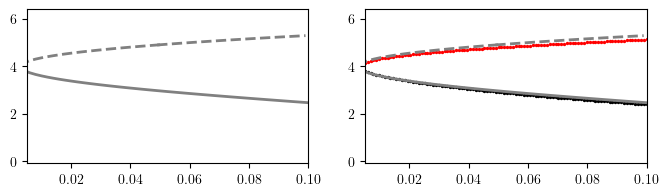

In [137]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [138]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.215

#### Branches eps stable

In [139]:
b=-.215
kw_b['recompute'] = False
kw_b['b'] = b

In [140]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=3.5,eps_init=0.11,eps_final=0,deps=-.002)]

In [141]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 3.5


In [142]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [143]:
kw_b['recompute'] = False
kw_b['b'] = b

In [144]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5.5,eps_init=0.05,eps_final=0.0,deps=-1),return_point=True,**kw_b)

phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.215_ei=0.05_ef=0.0_de=-1.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.215_ei=0.05_ef=0.0_de=-1.txt


In [145]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=5.5,eps_init=0.05,eps_final=0,deps=-.002),
            dict(phi0=5.5,eps_init=0.049,eps_final=0.1,deps=.002)] 

In [146]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.215_ei=0.05_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.215_ei=0.05_ef=0_de=-0.002.txt
phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.215_ei=0.049_ef=0.1_de=0.002.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.215_ei=0.049_ef=0.1_de=0.002.txt


In [147]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

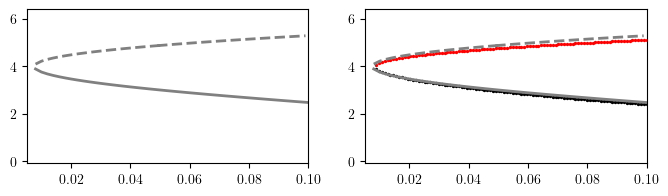

In [148]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [149]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.00809999999999991 3.878514387293541
phi init 3.878514387293541
Y [-0.10480819  0.23253365  0.09607191  0.40183516 -1.47939191  1.36070072  0.04228515  6.28308982]
mkdir ./data/vdp_thal11_b0=-0.215/
* Loading LC data...
self.T 6.2830898131014825
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.000541746692777415
es_min,phi0 0.00859999999999991 3.878514387293541
phi init 3.878514387293541
Y [-0.1048045   0.2256308   0.09593096  0.40971824 -1.54425065  1.28736824  0.03837659  6.28313501]
mkdir ./data/vdp_thal11_b1=-0.215/
* Loading LC data...
self.T 6.283135008620591
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0007717488653141119
es_min,phi0 0.00909999999999991 3.878514387293541
phi init 3.878514387293541
Y [-0.10476168  0.23061762  0.09583378  0.40401186 -1.57758629  1.24662372  0.03642448  6.28317199]
mkdir ./data/vdp_thal11_b2=-0.215/
* Loading LC data...
self.T 6.283171985521309
loaded coupling expansions

(0.995, 1.005)

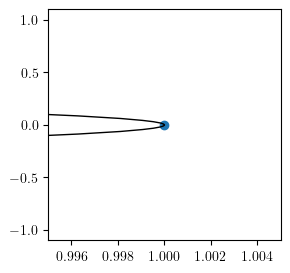

In [150]:
fig,axs = plt.subplots(figsize=(3,3))
axs.scatter(m1.eigenvalues.real,m1.eigenvalues.imag)

circ = Circle((0, 0), radius=1, edgecolor='k', facecolor='None'); axs.add_patch(circ)
axs.set_xlim(.995,1.005)

In [151]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.22

#### Branches eps stable

In [152]:
b=-.22
kw_b['recompute'] = False
kw_b['b'] = b

In [153]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=3,eps_init=0.11,eps_final=0,deps=-.002)]

In [154]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 3


In [155]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [156]:
kw_b['recompute'] = False
kw_b['b'] = b

In [157]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5.5,eps_init=0.05,eps_final=0.0,deps=-1),return_point=True,**kw_b)

phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.22_ei=0.05_ef=0.0_de=-1.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.22_ei=0.05_ef=0.0_de=-1.txt


In [158]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=5.5,eps_init=0.05,eps_final=0,deps=-.002),
            dict(phi0=5.5,eps_init=0.049,eps_final=0.1,deps=.002)] 

In [159]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.22_ei=0.05_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.22_ei=0.05_ef=0_de=-0.002.txt
phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.22_ei=0.049_ef=0.1_de=0.002.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.22_ei=0.049_ef=0.1_de=0.002.txt


In [160]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

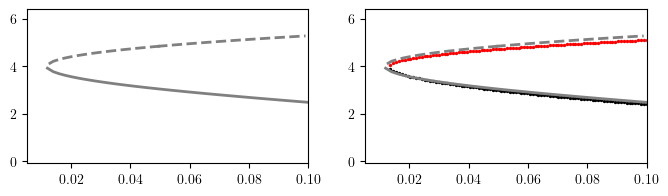

In [161]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [162]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.012099999999999913 3.9117153664751956
phi init 3.9117153664751956
Y [-0.10510466  0.22833749  0.09457491  0.40616016 -1.44574051  1.39811517  0.04448108  6.28298807]
mkdir ./data/vdp_thal11_b0=-0.22/
* Loading LC data...
self.T 6.282988066146776
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0006384863105946218
es_min,phi0 0.012599999999999913 3.9117153664751956
phi init 3.9117153664751956
Y [-0.10505545  0.23098713  0.09451719  0.40314478 -1.50905257  1.33000791  0.04056617  6.28307486]
mkdir ./data/vdp_thal11_b1=-0.22/
* Loading LC data...
self.T 6.283074851570264
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.001021648248177788
es_min,phi0 0.013099999999999914 3.9117153664751956
phi init 3.9117153664751956
Y [-0.10501784  0.23072568  0.09443131  0.4034547  -1.55649914  1.27452549  0.03773425  6.28313699]
mkdir ./data/vdp_thal11_b2=-0.22/
* Loading LC data...
self.T 6.2831369924062805
loaded coupling expa

In [163]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

In [164]:
print(es,eu)

0.11 0.09900000000000005


### b=-.25

#### Branches eps stable

In [165]:
b=-.25
kw_b['recompute'] = False
kw_b['b'] = b

In [166]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=3,eps_init=0.11,eps_final=0,deps=-.002)]

In [167]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 3


In [168]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [169]:
kw_b['recompute'] = False
kw_b['b'] = b

In [170]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5.5,eps_init=0.05,eps_final=0.0,deps=-1),return_point=True,**kw_b)

phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.25_ei=0.05_ef=0.0_de=-1.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.25_ei=0.05_ef=0.0_de=-1.txt


In [171]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=5.5,eps_init=0.05,eps_final=0,deps=-.002),
            dict(phi0=5.5,eps_init=0.049,eps_final=0.1,deps=.002)] 

In [172]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.25_ei=0.05_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.25_ei=0.05_ef=0_de=-0.002.txt
phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.25_ei=0.049_ef=0.1_de=0.002.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.25_ei=0.049_ef=0.1_de=0.002.txt


In [173]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

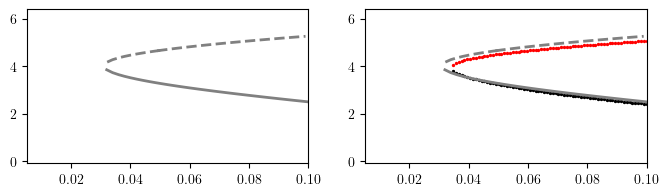

In [174]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [175]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.032099999999999934 3.844113372719774
phi init 3.844113372719774
Y [-0.10623181  0.2304363   0.08801341  0.40169937 -1.5294193   1.31505352  0.03971059  6.28297436]
mkdir ./data/vdp_thal11_b0=-0.25/
* Loading LC data...
self.T 6.282974356535214
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0032864040604603587
es_min,phi0 0.032599999999999935 3.844113372719774
phi init 3.844113372719774
Y [-0.10609254  0.22595581  0.08804958  0.40699774 -1.58186247  1.25128614  0.03658877  6.28312856]
mkdir ./data/vdp_thal11_b1=-0.25/
* Loading LC data...
self.T 6.283128565660326
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.003992324960078253
es_min,phi0 0.033099999999999935 3.844113372719774
phi init 3.844113372719774
Y [-0.10597083  0.2264359   0.08808769  0.40653135 -1.61842686  1.20328697  0.03446018  6.28325669]
mkdir ./data/vdp_thal11_b2=-0.25/
* Loading LC data...
self.T 6.283256693123642
loaded coupling expansions


In [176]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

In [177]:
print(es,eu)

0.11 0.09900000000000005


### b=-.3

#### Branches eps stable

In [178]:
b=-.3
kw_b['recompute'] = False
kw_b['b'] = b

In [179]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=3,eps_init=0.11,eps_final=0,deps=-.002)]

In [180]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 3


In [181]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [182]:
kw_b['recompute'] = False
kw_b['b'] = b

In [183]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5.5,eps_init=0.05,eps_final=0.0,deps=-1),return_point=True,**kw_b)

phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.3_ei=0.05_ef=0.0_de=-1.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.3_ei=0.05_ef=0.0_de=-1.txt


In [184]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=5.5,eps_init=0.05,eps_final=0,deps=-.002),
            dict(phi0=5.5,eps_init=0.049,eps_final=0.1,deps=.002)] 

In [185]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.3_ei=0.05_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.3_ei=0.05_ef=0_de=-0.002.txt
phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.3_ei=0.049_ef=0.1_de=0.002.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.3_ei=0.049_ef=0.1_de=0.002.txt


In [186]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

In [187]:
data_bs_list

[array([[1.10000000e-01, 6.31886568e+00, 2.25163715e+00],
        [1.08000000e-01, 6.31646565e+00, 2.28850233e+00],
        [1.06000000e-01, 6.31446563e+00, 2.32584526e+00],
        [1.04000000e-01, 6.31206561e+00, 2.36296345e+00],
        [1.02000000e-01, 6.31006559e+00, 2.40055517e+00],
        [1.00000000e-01, 6.30806557e+00, 2.43836995e+00],
        [9.80000000e-02, 6.30626555e+00, 2.47652872e+00],
        [9.60000000e-02, 6.30426553e+00, 2.51498839e+00],
        [9.40000000e-02, 6.30266551e+00, 2.55370918e+00],
        [9.20000000e-02, 6.30106549e+00, 2.59284851e+00],
        [9.00000000e-02, 6.29946548e+00, 2.63240668e+00],
        [8.80000000e-02, 6.29806546e+00, 2.67269823e+00],
        [8.60000000e-02, 6.29686545e+00, 2.71352022e+00],
        [8.40000000e-02, 6.29546543e+00, 2.75464489e+00],
        [8.20000000e-02, 6.29426542e+00, 2.79669727e+00],
        [8.00000000e-02, 6.29326541e+00, 2.83967388e+00],
        [7.80000000e-02, 6.29226540e+00, 2.88326329e+00],
        [7.600

#### Plot combined 1 par

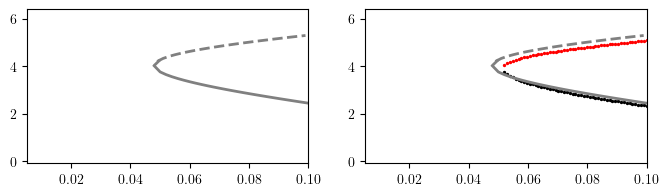

In [188]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [189]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.04809999999999995 4.012140011318708
phi init 4.012140011318708
Y [-0.10810332  0.22661269  0.08199018  0.40356945 -1.36207304  1.49626567  0.05086198  6.28194892]
mkdir ./data/vdp_thal11_b0=-0.3/
* Loading LC data...
self.T 6.281948908155876
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0018395372923084232
es_min,phi0 0.04859999999999995 4.012140011318708
phi init 4.012140011318708
Y [-0.10751732  0.22672532  0.08246067  0.4039532  -1.48338869  1.37431717  0.04288822  6.28259932]
mkdir ./data/vdp_thal11_b1=-0.3/
* Loading LC data...
self.T 6.282599322957034
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.004431647133547311
es_min,phi0 0.04909999999999995 4.012140011318708
phi init 4.012140011318708
Y [-0.10720864  0.22332918  0.08272542  0.40821406 -1.55724864  1.28893688  0.03834444  6.282953  ]
mkdir ./data/vdp_thal11_b2=-0.3/
* Loading LC data...
self.T 6.282953002258344
loaded coupling expansions
* Load

In [190]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.35

#### Branches eps stable

In [191]:
b=-.35
kw_b['recompute'] = False
kw_b['b'] = b

In [192]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=2,eps_init=0.11,eps_final=0,deps=-.002)]

In [193]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2


In [194]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [195]:
kw_b['recompute'] = False
kw_b['b'] = b

In [196]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5.2,eps_init=0.07,eps_final=0.0,deps=-1),return_point=True,**kw_b)

phi init 5.2
phase_diffs_u_init=5.2_nm=11_b=-0.35_ei=0.07_ef=0.0_de=-1.txt
phase_diffs_u_pt_init=5.2_nm=11_b=-0.35_ei=0.07_ef=0.0_de=-1.txt


In [197]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=5,eps_init=0.07,eps_final=0,deps=-.002),
            dict(phi0=5,eps_init=0.069,eps_final=0.1,deps=.002)] 

In [198]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5
phase_diffs_u_init=5_nm=11_b=-0.35_ei=0.07_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=5_nm=11_b=-0.35_ei=0.07_ef=0_de=-0.002.txt
phi init 5
phase_diffs_u_init=5_nm=11_b=-0.35_ei=0.069_ef=0.1_de=0.002.txt
phase_diffs_u_pt_init=5_nm=11_b=-0.35_ei=0.069_ef=0.1_de=0.002.txt


In [199]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

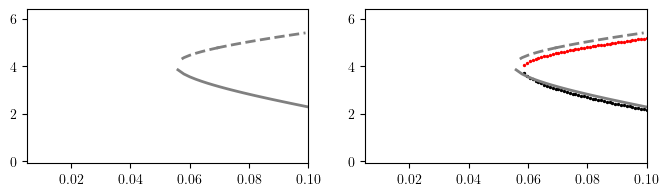

In [200]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [201]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.056099999999999955 3.8422356194983074
phi init 3.8422356194983074
Y [-0.10763525  0.22611613  0.08057069  0.40417251 -1.5461657   1.30501769  0.03912791  6.28288186]
mkdir ./data/vdp_thal11_b0=-0.35/
* Loading LC data...
self.T 6.2828818610470645
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.006951709278037332
es_min,phi0 0.056599999999999956 3.8422356194983074
phi init 3.8422356194983074
Y [-0.10726396  0.23083555  0.08097216  0.39900359 -1.60493875  1.23021788  0.03559316  6.28326501]
mkdir ./data/vdp_thal11_b1=-0.35/
* Loading LC data...
self.T 6.283265013517122
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.008727654927036577
es_min,phi0 0.057099999999999956 3.8422356194983074
phi init 3.8422356194983074
Y [-0.10690986  0.2299926   0.08130566  0.40031797 -1.65796498  1.15629491  0.03251388  6.28356586]
mkdir ./data/vdp_thal11_b2=-0.35/
* Loading LC data...
self.T 6.283565865805188
loaded coupling expan

In [202]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.4

#### Branches eps stable

In [203]:
b=-.4
kw_b['recompute'] = False
kw_b['b'] = b

In [204]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=3,eps_init=0.11,eps_final=0,deps=-.002),
]

In [205]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 3


In [206]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [207]:
kw_b['recompute'] = False
kw_b['b'] = b

In [208]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5.5,eps_init=0.07,eps_final=0.0,deps=-1),return_point=True,**kw_b)

phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.4_ei=0.07_ef=0.0_de=-1.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.4_ei=0.07_ef=0.0_de=-1.txt


In [209]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=5.5,eps_init=0.07,eps_final=0,deps=-.002),
            dict(phi0=5.5,eps_init=0.069,eps_final=0.1,deps=.002),
           ] 

In [210]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.4_ei=0.07_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.4_ei=0.07_ef=0_de=-0.002.txt
phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.4_ei=0.069_ef=0.1_de=0.002.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.4_ei=0.069_ef=0.1_de=0.002.txt


In [211]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

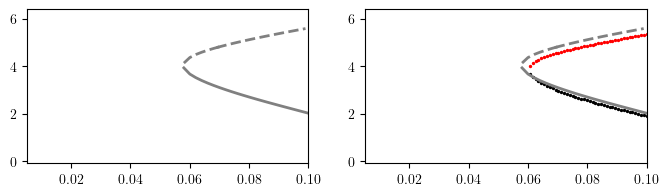

In [212]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [213]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.05809999999999996 3.9245403547136695
phi init 3.9245403547136695
Y [-0.10838899  0.22349797  0.07930115  0.40645178 -1.45670153  1.40719226  0.04479604  6.2822863 ]
mkdir ./data/vdp_thal11_b0=-0.4/
* Loading LC data...
self.T 6.282286303058147
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.004848039202466169
es_min,phi0 0.05859999999999996 3.9245403547136695
phi init 3.9245403547136695
Y [-0.10764902  0.22528695  0.07998779  0.40500938 -1.56809996  1.27901382  0.03784036  6.2829954 ]
mkdir ./data/vdp_thal11_b1=-0.4/
* Loading LC data...
self.T 6.2829954005528466
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.007922033087669797
es_min,phi0 0.05909999999999996 3.9245403547136695
phi init 3.9245403547136695
Y [-0.10713696  0.22667174  0.0805173   0.40386115 -1.64109872  1.18162274  0.03352413  6.28345009]
mkdir ./data/vdp_thal11_b2=-0.4/
* Loading LC data...
self.T 6.28345008928389
loaded coupling expansions
*

In [214]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.5

#### Branches eps stable

In [215]:
b=-.5
kw_b['recompute'] = False
kw_b['b'] = b

In [216]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2,eps_init=0.08,eps_final=0,deps=-.002),
    dict(phi0=2,eps_init=0.079,eps_final=0.1,deps=.002),
]

In [217]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2


In [218]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [219]:
kw_b['recompute'] = False
kw_b['b'] = b

In [220]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5.5,eps_init=0.07,eps_final=0.0,deps=-1),return_point=True,**kw_b)

phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.5_ei=0.07_ef=0.0_de=-1.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.5_ei=0.07_ef=0.0_de=-1.txt


In [221]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=5.5,eps_init=0.07,eps_final=0,deps=-.002),
            dict(phi0=5.5,eps_init=0.069,eps_final=0.1,deps=.002)] 

In [222]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.5_ei=0.07_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.5_ei=0.07_ef=0_de=-0.002.txt
phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.5_ei=0.069_ef=0.1_de=0.002.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.5_ei=0.069_ef=0.1_de=0.002.txt


In [223]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

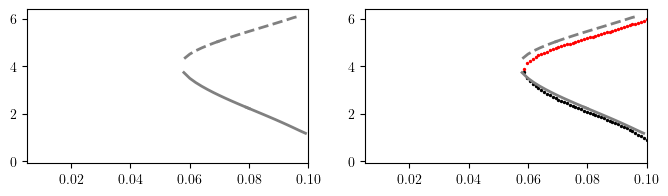

In [224]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [225]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0002*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.05799999999999998 3.7281539403030695
phi init 3.7281539403030695
Y [-0.10688621  0.22459108  0.0811048   0.40660499 -1.67241286  1.13549288  0.03171122  6.28361329]
mkdir ./data/vdp_thal11_b0=-0.5/
* Loading LC data...
self.T 6.28361329472511
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.010608969111238115
es_min,phi0 0.05819999999999998 3.7281539403030695
phi init 3.7281539403030695
Y [-0.10663026  0.22798127  0.08142151  0.40288754 -1.70156143  1.0900303   0.03004838  6.28381429]
mkdir ./data/vdp_thal11_b1=-0.5/
* Loading LC data...
self.T 6.283814293322462
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.011610813618387547
es_min,phi0 0.05839999999999998 3.7281539403030695
phi init 3.7281539403030695
Y [-0.10642878  0.23041581  0.0817227   0.40026484 -1.72842178  1.04570191  0.02853478  6.28399445]
mkdir ./data/vdp_thal11_b2=-0.5/
* Loading LC data...
self.T 6.283994446612615
loaded coupling expansions
* 

In [226]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.8

#### Branches eps stable

In [227]:
b=-.8
kw_b['recompute'] = False
kw_b['b'] = b

In [228]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2,eps_init=0.055,eps_final=0,deps=-.001),
    dict(phi0=2,eps_init=0.054,eps_final=0.1,deps=.001,max_iter=50),
]

In [229]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2


In [230]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [231]:
kw_b['recompute'] = False
kw_b['b'] = b

In [232]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5,eps_init=0.055,eps_final=0.0,deps=-1),return_point=True,**kw_b)

phi init 5
phase_diffs_u_init=5_nm=11_b=-0.8_ei=0.055_ef=0.0_de=-1.txt
phase_diffs_u_pt_init=5_nm=11_b=-0.8_ei=0.055_ef=0.0_de=-1.txt


In [233]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=5.5,eps_init=0.055,eps_final=0,deps=-.001),
            dict(phi0=5.5,eps_init=0.054,eps_final=0.1,deps=.001)] 

In [234]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.8_ei=0.055_ef=0_de=-0.001.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.8_ei=0.055_ef=0_de=-0.001.txt
phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-0.8_ei=0.054_ef=0.1_de=0.001.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-0.8_ei=0.054_ef=0.1_de=0.001.txt


In [235]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

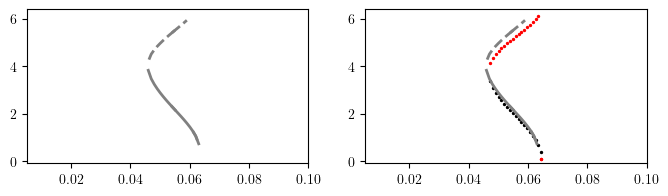

In [236]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [237]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0002*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.04599999999999999 3.8217127120670877
phi init 3.8217127120670877
Y [-0.10699517  0.23065183  0.08372558  0.40001302 -1.54943025  1.29681313  0.03874387  6.28298439]
mkdir ./data/vdp_thal11_b0=-0.8/
* Loading LC data...
self.T 6.2829843939935985
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0055667298276654755
es_min,phi0 0.04619999999999999 3.8217127120670877
phi init 3.8217127120670877
Y [-0.10634636  0.2314111   0.08455666  0.39978026 -1.66944039  1.13524759  0.03171172  6.28355749]
mkdir ./data/vdp_thal11_b1=-0.8/
* Loading LC data...
self.T 6.283557490662254
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.008105710981667583
es_min,phi0 0.04639999999999999 3.8217127120670877
phi init 3.8217127120670877
Y [-0.10582319  0.22568246  0.0852411   0.40693346 -1.75735025  0.99105183  0.02680237  6.2839438 ]
mkdir ./data/vdp_thal11_b2=-0.8/
* Loading LC data...
self.T 6.283943804836795
loaded coupling expansions

#### Monodromys max

In [238]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-.0001-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.0629 0.7284968169985353
phi init 0.7284968169985353
Y [-0.09964899  0.23221878  0.11836555  0.4093949   1.09299374 -1.08644292  0.22849536  6.30163174]
mkdir ./data/vdp_thal11_b0=-0.8/
* Loading LC data...
self.T 6.2829843939935985
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0055667298276654755
es_min,phi0 0.0624 0.7284968169985353
phi init 0.7284968169985353
Y [-0.09767867  0.23259791  0.12158596  0.40974914  0.93411573 -1.30570675  0.07704077  6.30788078]
mkdir ./data/vdp_thal11_b1=-0.8/
* Loading LC data...
self.T 6.283557490662254
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.008105710981667583
es_min,phi0 0.0619 0.7284968169985353
phi init 0.7284968169985353
Y [-0.0968663   0.22986537  0.12327854  0.4131713   0.79323641 -1.45752716  0.0212298   6.31126797]
mkdir ./data/vdp_thal11_b2=-0.8/
* Loading LC data...
self.T 6.283943804836795
loaded coupling expansions
* Loading monodromy...
* Floquet Expon

In [239]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-1

#### Branches eps stable

In [240]:
b=-1
kw_b['recompute'] = False
kw_b['b'] = b

In [241]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=2,eps_init=0.045,eps_final=0.03,deps=-.0002),
    dict(phi0=2,eps_init=0.044,eps_final=0.05,deps=.0002),
]

In [242]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2


In [243]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [244]:
kw_b['recompute'] = False
kw_b['b'] = b

In [245]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5,eps_init=0.045,eps_final=0.0,deps=-1),return_point=True,**kw_b)

phi init 5
phase_diffs_u_init=5_nm=11_b=-1_ei=0.045_ef=0.0_de=-1.txt
phase_diffs_u_pt_init=5_nm=11_b=-1_ei=0.045_ef=0.0_de=-1.txt


In [246]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=5.5,eps_init=0.045,eps_final=0.03,deps=-.0002),
            dict(phi0=5.5,eps_init=0.044,eps_final=0.05,deps=.0002)] 

In [247]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-1_ei=0.045_ef=0.03_de=-0.0002.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-1_ei=0.045_ef=0.03_de=-0.0002.txt
phi init 5.5
phase_diffs_u_init=5.5_nm=11_b=-1_ei=0.044_ef=0.05_de=0.0002.txt
phase_diffs_u_pt_init=5.5_nm=11_b=-1_ei=0.044_ef=0.05_de=0.0002.txt


In [248]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

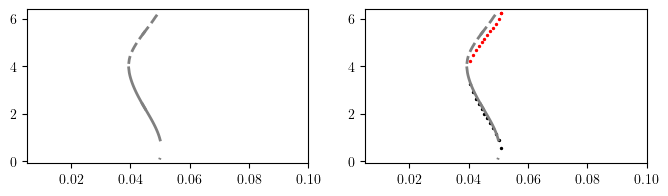

In [249]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [250]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)

eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.039500000000000035 3.9266907794868975
phi init 3.9266907794868975
Y [-0.10647237  0.22980712  0.08590112  0.40182706 -1.57764189  1.25926284  0.03694559  6.2831232 ]
mkdir ./data/vdp_thal11_b0=-1/
* Loading LC data...
self.T 6.28312319826599
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.005059793542852416
es_min,phi0 0.040000000000000036 3.9266907794868975
phi init 3.9266907794868975
Y [-0.10488908  0.23109885  0.08835599  0.4019507  -1.86809624  0.75264441  0.02060637  6.28436777]
mkdir ./data/vdp_thal11_b1=-1/
* Loading LC data...
self.T 6.284367772490845
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.01078751012589868
es_min,phi0 0.040500000000000036 3.9266907794868975
phi init 3.9266907794868975
Y [-0.10386481  0.22820744  0.09041716  0.40634042 -1.97572528  0.37120498  0.01387276  6.28514562]
mkdir ./data/vdp_thal11_b2=-1/
* Loading LC data...
self.T 6.285145624370315
loaded coupling expansions
* Load

#### Monodromys max

In [251]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-.0001-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.04989999999999996 0.8911584011325759
phi init 0.8911584011325759
Y [-0.09906569  0.23021813  0.11680383  0.4110812   1.00665946 -1.37846928  0.12213448  6.30180198]
mkdir ./data/vdp_thal11_b0=-1/
* Loading LC data...
self.T 6.28312319826599
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.005059793542852416
es_min,phi0 0.04939999999999996 0.8911584011325759
phi init 0.8911584011325759
Y [-0.09804259  0.234158    0.11869544  0.40726208  0.74050842 -1.59952772  0.01195522  6.30576908]
mkdir ./data/vdp_thal11_b1=-1/
* Loading LC data...
self.T 6.284367772490845
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.01078751012589868
es_min,phi0 0.04889999999999996 0.8911584011325759
phi init 0.8911584011325759
Y [-9.76694252e-02  2.31296009e-01  1.19198101e-01  4.10608972e-01  5.00511191e-01 -1.73979033e+00  1.24891580e-03  6.30749803e+00]
mkdir ./data/vdp_thal11_b2=-1/
* Loading LC data...
self.T 6.285145624370315
load

In [252]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

# Two parameter full

In [253]:
twopar_neg = np.loadtxt('../v2_bifdat_2par/redu/vdp_thal_11_o2_neg_fixed.dat')
twopar_neg2 = np.loadtxt('../v2_bifdat_2par/redu/vdp_thal_11_o2_neg2_fixed.dat')
twopar_pos = np.loadtxt('../v2_bifdat_2par/redu/vdp_thal_11_o2_pos_fixed.dat')

(-1.01, 0.05)

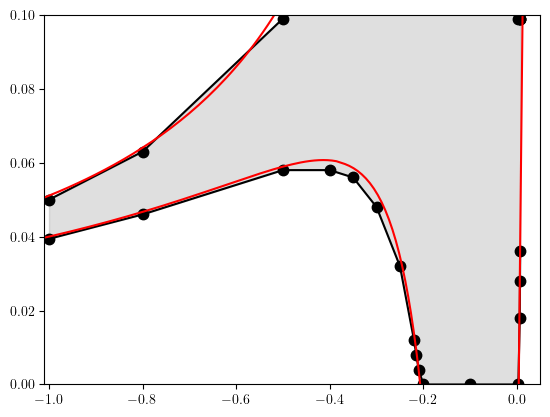

In [254]:
fig,axs = plt.subplots()
axs.fill_between(b_vals_full,e_vals_full,e_hi_full,color='gray',alpha=.25)
axs.plot(b_vals_full,e_vals_full,marker='.',color='k',markersize=15)
axs.plot(b_vals_full,e_hi_full,marker='.',color='k',markersize=15)

axs.plot(twopar_neg[:,1],twopar_neg[:,0],color='r')
axs.plot(twopar_neg2[:,1],twopar_neg2[:,0],color='r')
axs.plot(twopar_pos[:,1],twopar_pos[:,0],color='r')

axs.set_ylim(0,.1)
axs.set_xlim(-1.01,.05)

In [255]:
fname_lo = '../v2_bifdat_2par/full/vdp_thal_2par_lo_{}{}.dat'.format(a._n[1],a._m[1])
fname_hi = '../v2_bifdat_2par/full/vdp_thal_2par_hi_{}{}.dat'.format(a._n[1],a._m[1])

arr_lo = np.zeros([len(b_vals_full),2])
arr_hi = np.zeros([len(b_vals_full),2])

arr_lo[:,0] = b_vals_full
arr_lo[:,1] = e_vals_full

arr_hi[:,0] = b_vals_full
arr_hi[:,1] = e_hi_full

np.savetxt(fname_lo,arr_lo)
np.savetxt(fname_hi,arr_hi)

# Eigenvalue Convergence Plot

## Min

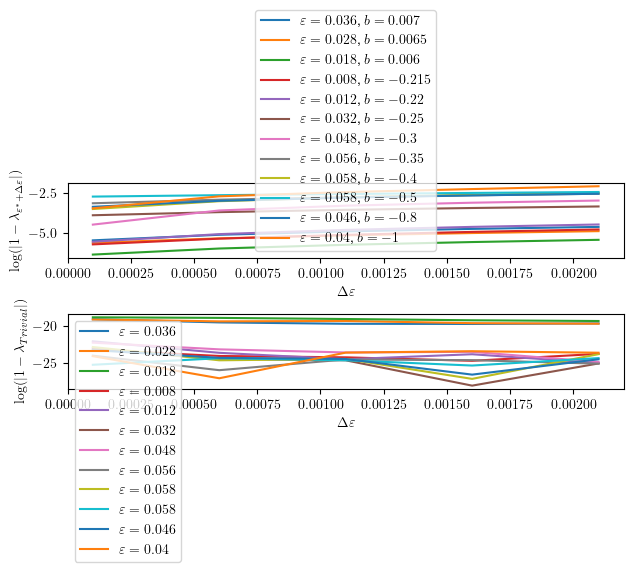

In [256]:
fig,axs = plt.subplots(2,1)

#es_min+.0001+0.0005*i
#ee = es_max-.0001-0.0005*i
eps_values = np.arange(0.0001,0.0001+0.0005*5,.0005)
skipn = 1

for j in range(len(eigenvalues_min_all[::skipn])):
    nn = len(eigenvalues_min_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_min_all[::skipn][j][i])
        
        min1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[min1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    
    ee = e_vals_mono_min[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_min_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*+\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_vdp_thal_min_{}{}.png'.format(a._n[1],a._m[1]))

## Max

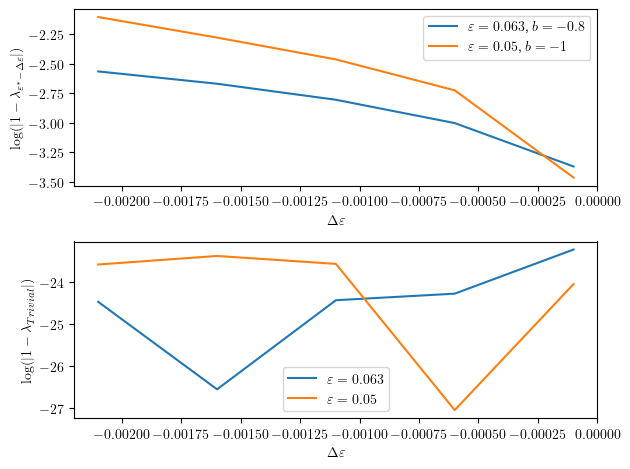

In [257]:
fig,axs = plt.subplots(2,1)

#es_min+.0001+0.0005*i
#ee = es_max-.0001-0.0005*i
eps_values = np.arange(-0.0001,0.0001-0.0005*5,-.0005)
skipn = 1

for j in range(len(eigenvalues_max_all[::skipn])):
    nn = len(eigenvalues_max_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_max_all[::skipn][j][i])
        
        max1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[max1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    ee = e_vals_mono_max[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_max_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*-\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_vdp_thal_max_{}{}.png'.format(a._n[1],a._m[1]))